In [24]:
# create dependencies
import pandas as pd
import glob
import csv
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns


In [62]:
# get directory where csv files are stored
csv_path = Path(r'C:\Users\thegr\Documents\UT Boot Camp\project-1\Resources\NOAA Storm Data')

# get a list of all csv files in the directory
csv_files = glob.glob(str(csv_path / '*.csv'))

# declare an empty dataframe to store csv data
storm_details_list = []

# specify which columns to read
columns_to_read = ['YEAR','MONTH_NAME', 'STATE', 'EVENT_TYPE', 'INJURIES_DIRECT', 'DEATHS_DIRECT', 'DAMAGE_PROPERTY']

# loop through each CSV file and read it into the dataframe
for csv_file in csv_files:
    df = pd.read_csv(csv_file, usecols=columns_to_read)
    storm_details_list.append(df)

# combine lists into one dataframe
storm_details_df = pd.concat(storm_details_list, ignore_index=True)

# columns to keep:  Hurricane (Typhoon), Flash Flood, Wildfire, 
storm_details_df_filtered = storm_details_df[storm_details_df['EVENT_TYPE'].isin(['Hurricane (Typhoon)', 'Tornado', 'Flood', 'Wildfire', 'Winter Storm'])]


In [64]:
# Function to convert DAMAGE_PROPERTY to integers
def convert_damage(value):
    if isinstance(value, str):
        # Remove commas
        value = value.replace(",", "")
        
        # Check for empty string after removing commas
        if value == "":  # If the string is empty after removing commas
            return 0
        
        # convert K, M, B suffixes for thousand, million, and billion into integers
        if value[-1] in ('K', 'M', 'B'):
            try:
                if value[-1] == 'K':
                    multiplier = 1_000
                elif value[-1] == 'M':
                    multiplier = 1_000_000
                elif value[-1] == 'B':
                    multiplier = 1_000_000_000

                # Convert the number part and apply the multiplier
                return int(float(value[:-1]) * multiplier)
            except ValueError:
                return 0  # Handle conversion errors
        else:
            try:
                # Convert directly if no K, M, or B suffix
                return int(value)
            except ValueError:
                return 0  # Handle conversion errors
    return 0  # Return 0 for NaN or unrecognized formats

storm_details_df_filtered['DAMAGE_PROPERTY'] = storm_details_df_filtered['DAMAGE_PROPERTY'].apply(convert_damage)

# Group by 'STATE' and 'MONTH_NAME', then aggregate the data
storm_summary = (
    storm_details_df_filtered.groupby(['STATE', 'EVENT_TYPE', 'YEAR'])
    .agg({
        'INJURIES_DIRECT': 'sum',       # Sum of direct injuries
        'DEATHS_DIRECT': 'sum',         # Sum of direct deaths
        'DAMAGE_PROPERTY': 'sum'        # Sum of property damage (assuming it's numeric)
    })
    .reset_index()  # Reset index for a cleaner DataFrame
)

C:\Users\thegr\AppData\Local\Temp\ipykernel_167364\3237877210.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storm_details_df_filtered['DAMAGE_PROPERTY'] = storm_details_df_filtered['DAMAGE_PROPERTY'].apply(convert_damage)


In [66]:
# remove rows that have all zeroes
storm_summary = storm_summary[(storm_summary[['INJURIES_DIRECT', 'DEATHS_DIRECT', 'DAMAGE_PROPERTY']] != 0).any(axis=1)]

storm_summary

,STATE,EVENT_TYPE,YEAR,INJURIES_DIRECT,DEATHS_DIRECT,DAMAGE_PROPERTY
1,ALABAMA,Flood,2005,0,0,65000
3,ALABAMA,Flood,2008,0,0,5000
4,ALABAMA,Flood,2009,0,0,2687000
5,ALABAMA,Flood,2010,0,0,2018000
6,ALABAMA,Flood,2011,0,0,35000
...,...,...,...,...,...,...
3488,WYOMING,Winter Storm,2008,0,0,8000
3489,WYOMING,Winter Storm,2009,0,0,45000
3493,WYOMING,Winter Storm,2013,0,0,3772000
3496,WYOMING,Winter Storm,2016,0,0,15000


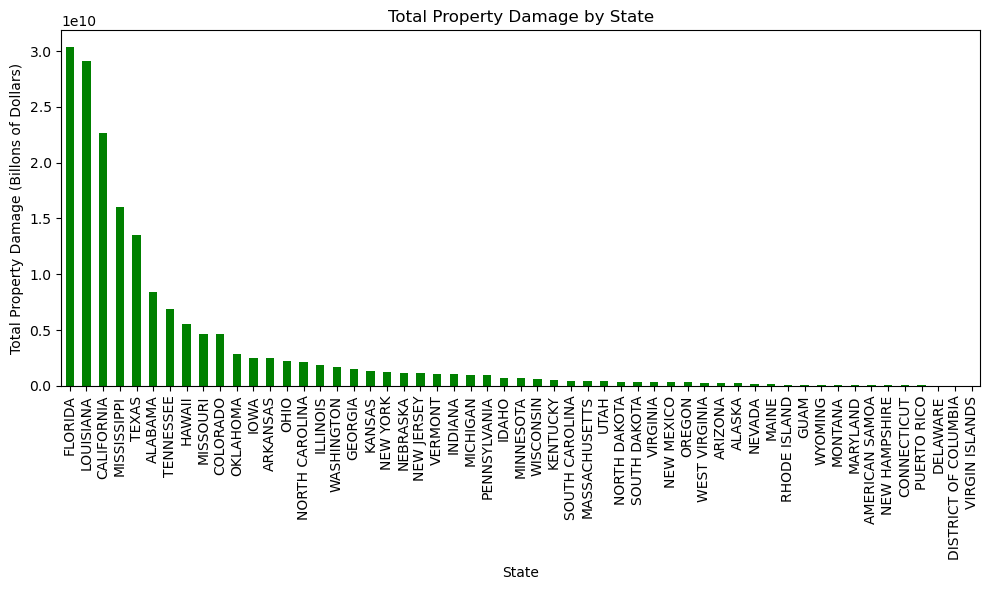

In [104]:
# create a bar chart to display this data of hurricane
# Filter data for a specific event type (e.g., 'Hurricane (Typhoon)')
#event_data = storm_summary[storm_summary['EVENT_TYPE'] == 'Hurricane (Typhoon)']

# Group by state and sum the property damage (or choose another metric if needed)
event_data_by_state = storm_summary.groupby('STATE')['DAMAGE_PROPERTY'].sum().sort_values(ascending=False)

# Plot bar chart directly with pandas
event_data_by_state.plot(kind='bar', figsize=(10, 6), color='green')
plt.xlabel('State')
plt.ylabel('Total Property Damage (Billons of Dollars)')
plt.title('Total Property Damage by State')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to fit labels


plt.savefig('total_property_damage_by_state.png')

plt.show()

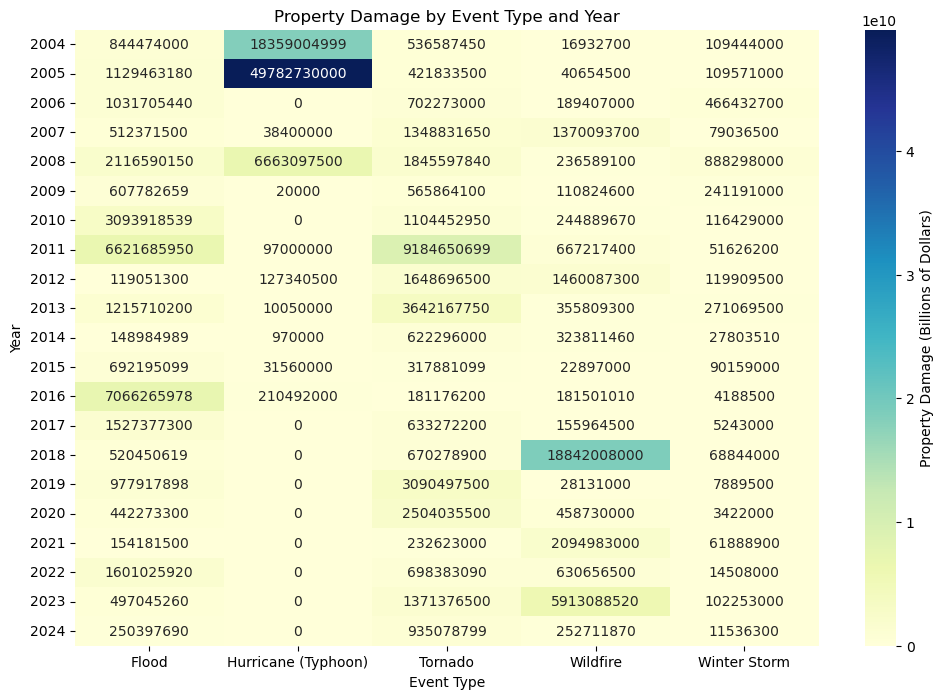

In [106]:
# Pivot data for heatmap
event_year_summary = storm_summary.pivot_table(index='YEAR', columns='EVENT_TYPE', values='DAMAGE_PROPERTY', aggfunc='sum').fillna(0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(event_year_summary, cmap='YlGnBu', annot=True, fmt='.0f', cbar_kws={'label': 'Property Damage (Billions of Dollars)'})
plt.xlabel('Event Type')
plt.ylabel('Year')
plt.title('Property Damage by Event Type and Year')

plt.savefig('Property Damage by Event Type and Year.png')

plt.show()

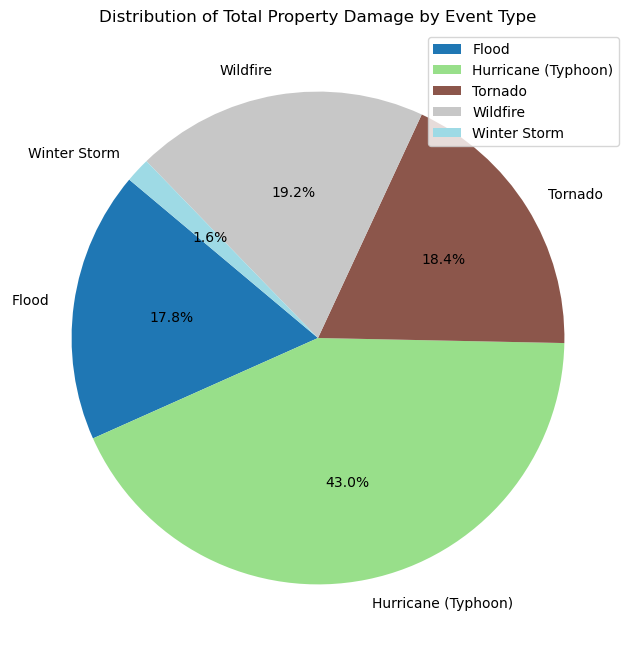

In [108]:
# create a pie chart to display this data
# Group data by event type and sum the property damage
event_damage = storm_summary.groupby('EVENT_TYPE')['DAMAGE_PROPERTY'].sum()

# Plot pie chart
plt.figure(figsize=(8, 8))
event_damage.plot(kind='pie', autopct='%1.1f%%', startangle=140, colormap='tab20', legend=True)
plt.ylabel('')  # Hide y-label for clarity
plt.title('Distribution of Total Property Damage by Event Type')

plt.savefig('pie_chart_damage_by_event_type.png')

plt.show()

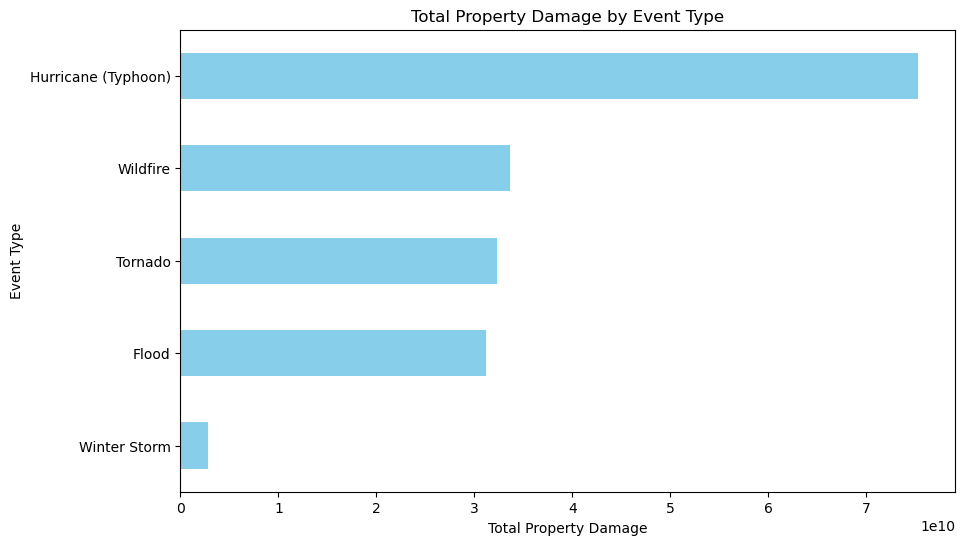

In [110]:
# Group by event type and sum damage and display per event type
event_summary = storm_summary.groupby('EVENT_TYPE')['DAMAGE_PROPERTY'].sum().sort_values()

# Plot bar chart
event_summary.plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.xlabel('Total Property Damage')
plt.ylabel('Event Type')
plt.title('Total Property Damage by Event Type')

plt.savefig('stacked_bar_chart_damage_by_event_type.png')

plt.show()

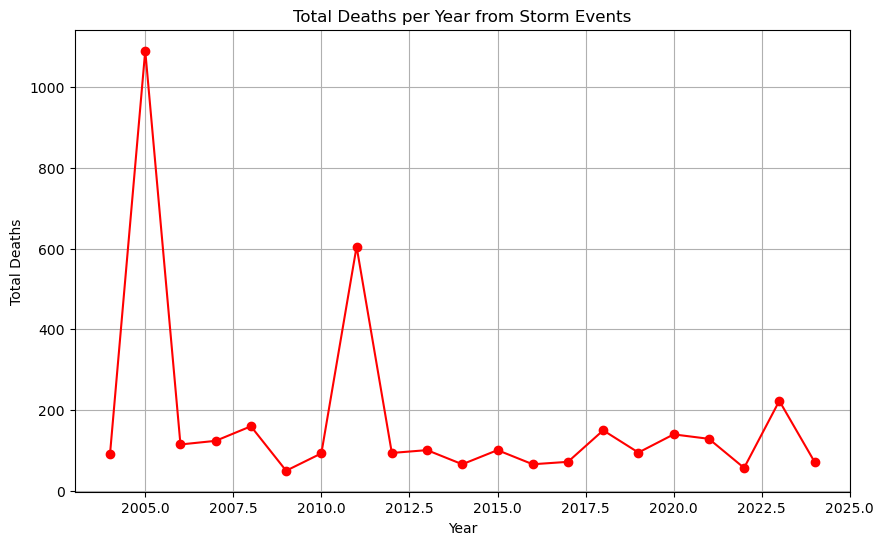

In [112]:
# Group by year and sum the deaths
# and display a line chart
deaths_per_year = storm_summary.groupby('YEAR')['DEATHS_DIRECT'].sum()

# Plot line chart
plt.figure(figsize=(10, 6))
deaths_per_year.plot(kind='line', marker='o', color='red')
plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.title('Total Deaths per Year from Storm Events')
plt.grid(True)

plt.savefig('line_chart_total_deaths_line.png')

plt.show()

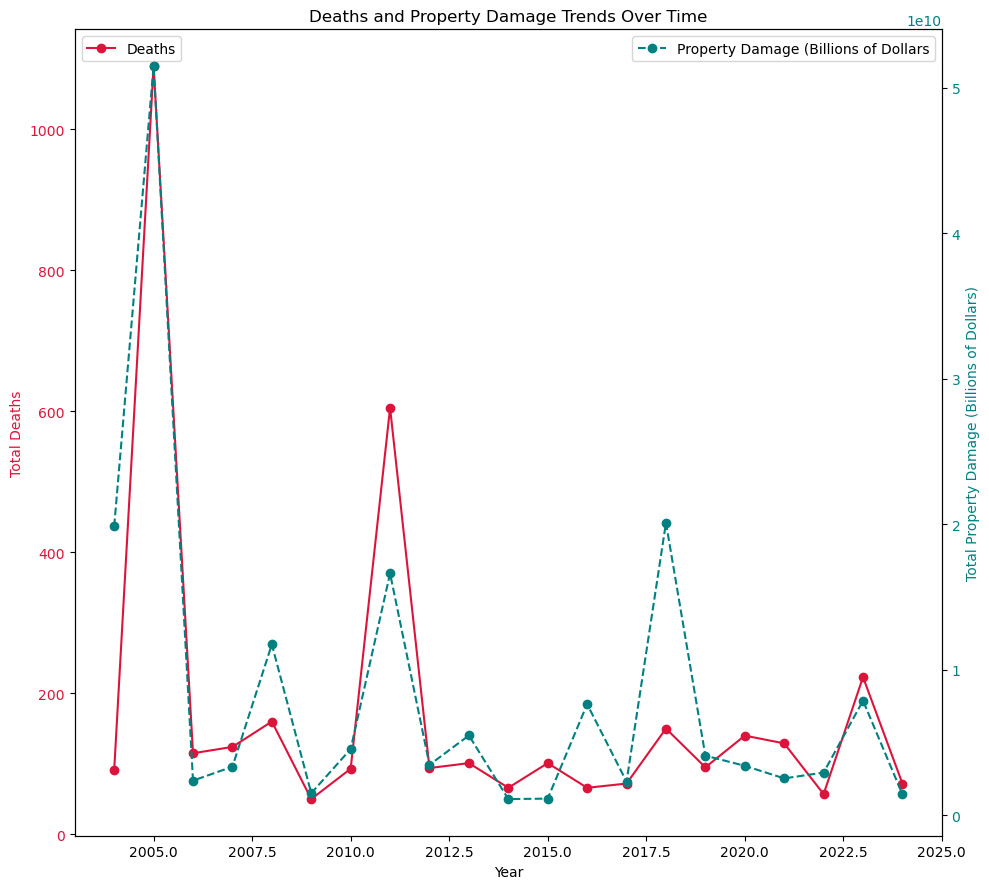

In [114]:
# Group data by year, summing deaths and property damage
deaths_and_damage = storm_summary.groupby('YEAR')[['DEATHS_DIRECT', 'DAMAGE_PROPERTY']].sum()

# Create a dual-axis line chart
fig, ax1 = plt.subplots(figsize=(10, 9))

# Plot deaths on the first y-axis
ax1.plot(deaths_and_damage.index, deaths_and_damage['DEATHS_DIRECT'], color='crimson', marker='o', label='Deaths')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Deaths', color='crimson')
ax1.tick_params(axis='y', labelcolor='crimson')

# Create a second y-axis for property damage
ax2 = ax1.twinx()
ax2.plot(deaths_and_damage.index, deaths_and_damage['DAMAGE_PROPERTY'], color='teal', marker='o', linestyle='--', label='Property Damage (Billions of Dollars')
ax2.set_ylabel('Total Property Damage (Billions of Dollars)', color='teal')
ax2.tick_params(axis='y', labelcolor='teal')

# Add titles and grid for clarity
plt.title('Deaths and Property Damage Trends Over Time')
fig.tight_layout()  # Adjust layout to fit both y-axis labels

# Optional: Add a legend
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.savefig('dual_line_chart_deaths_damage.png')

plt.show()